In [9]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

In [10]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [11]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [12]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on F1-score optimization.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = []
    true_labels = []

    for images, labels in test_data:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])

    # determine the best threshold
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        predicted_labels = [1 if p > thresh else 0 for p in predicted_probs]
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.2f}")
    
    # recalculate predictions with the best threshold
    final_predicted_labels = [1 if p > best_threshold else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [13]:
def build_model(base_model, transfer_learning):
    """
    Constructs a neural network model based on a specified base model and a transfer learning option.

    This function initializes a new model by setting the base model's trainable parameter according to 
    the transfer_learning flag ('Y' for non-trainable and 'N' for trainable). It modifies the input 
    layer to accommodate grayscale images and expands the single channel to three channels using a 
    Conv2D layer. The function then applies the base model and adds additional top layers for classification. 
    It returns the newly created model, which is suitable for binary classification tasks.

    Parameters:
    - base_model (keras.Model): The pre-existing model to use as the base.
    - transfer_learning (str): A flag ('Y' or 'N') indicating whether to freeze (non-trainable) or unfreeze 
      (trainable) the layers of the base model for transfer learning.

    Returns:
    - keras.Model: The constructed model ready for training.
    """
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True
    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the model
    x = base_model(x)

    # Add own top layers for classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model

In [14]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 748 files belonging to 2 classes.
Found 159 files belonging to 2 classes.
Found 166 files belonging to 2 classes.


In [15]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# CLASS WEIGHTS

In [16]:
from sklearn.utils.class_weight import compute_class_weight

labels = []
for _, label in train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
# class_weights = total_samples / (len(class_labels) * class_counts)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
class_weights_dict = dict(zip(class_labels, class_weights))
class_weights_dict = {int(key): value for key, value in class_weights_dict.items()}

In [17]:
class_weights_dict

{0: 0.06016042780748665, 1: 0.9398395721925134}

# IMAGE AUGMENTATION

In [18]:
def augment_image(image, label):
    # Randomly apply different augmentations to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    return image, label

# MODELO BASE ANN

In [19]:
# Apply the augmentation to the training dataset
train_data_augmented = train_data.map(augment_image)

### With class weights

In [20]:
basic_model = ''
# Definición de la red
basic_model = Sequential([
    # resizing
    Resizing(224,224, input_shape=(224, 224, 1)),
    # rescaling
    Rescaling(scale=1./255),
    # flatten
    Flatten(),
    # capa conectada
    Dense(1024, activation='relu'),
    # dropout
    Dropout(0.5),
    # capa de salida conectada
    Dense(1, activation='sigmoid')
])

In [21]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 1)       0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 51382273 (196.01 MB)
Trainable params: 513

In [22]:
# Compilación de la red
basic_model.compile(loss='binary_crossentropy', 
                    optimizer=Adam(learning_rate=1e-4), 
                    metrics=METRICS)

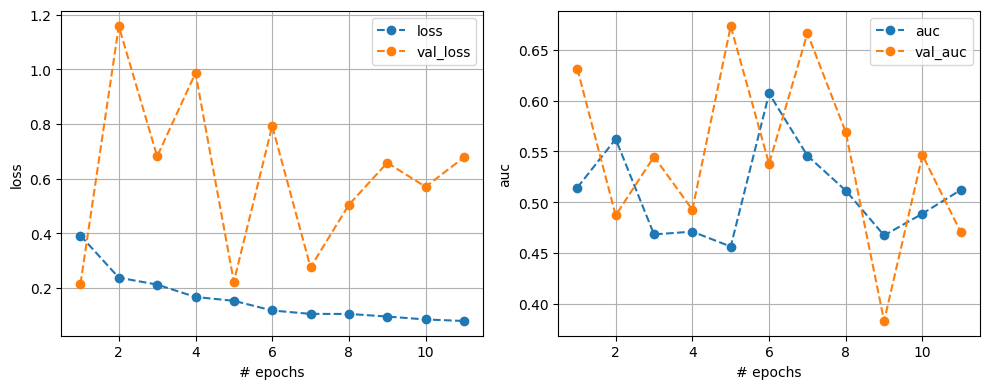

24/24 [==============================] - 3s 110ms/step - loss: 0.0794 - auc: 0.5121 - val_loss: 0.6781 - val_auc: 0.4704
Training time: 40.67658448219299 seconds


In [23]:
# Entrenamiento de la red
ann_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
ann_checkpoint = ModelCheckpoint('ann_best_weights.h5', save_best_only=True, save_weights_only=True)
ann_plot_callback = PlotLearning()

start = time.time()

history = basic_model.fit(train_data_augmented,#train_generator,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    epochs=150, 
                    batch_size=32,
                    callbacks=[ann_callback, ann_checkpoint, ann_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.45 with F1-score: 0.14


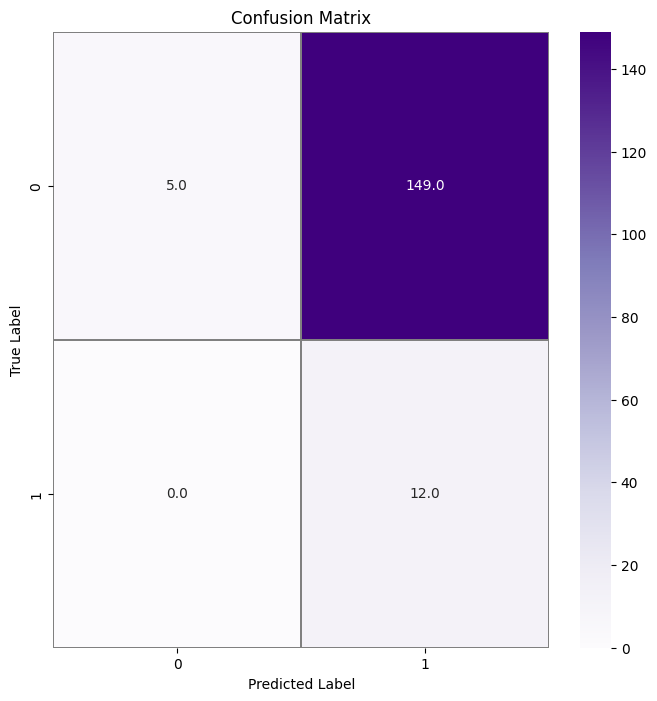

              precision    recall  f1-score   support

           0       1.00      0.03      0.06       154
           1       0.07      1.00      0.14        12

    accuracy                           0.10       166
   macro avg       0.54      0.52      0.10       166
weighted avg       0.93      0.10      0.07       166

  Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0        ANN  0.38                     0.14       0.1          1.0   

   Specificity   PPV  NPV   PLR  NLR  
0         0.03  0.07  1.0  1.03  0.0  


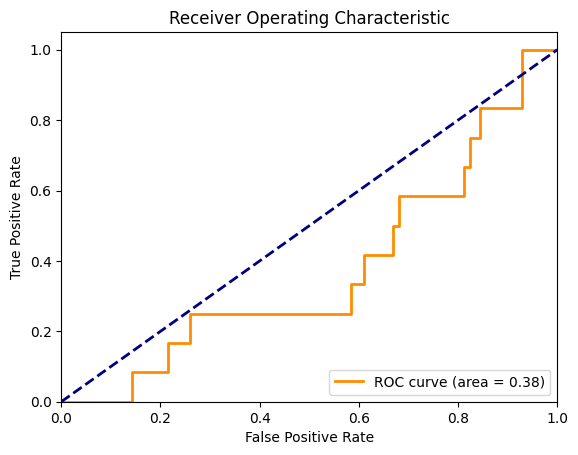

In [24]:
get_model_metrics(test_data=test_data, model=basic_model, model_name='ANN')

### Without class weights

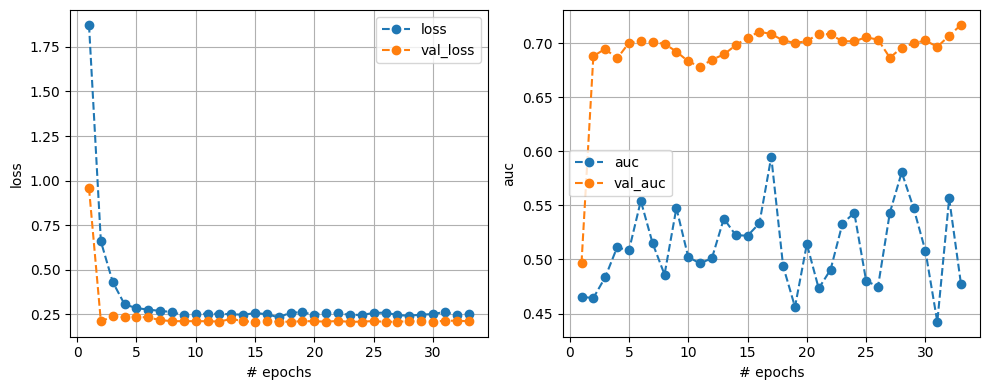

24/24 [==============================] - 4s 130ms/step - loss: 0.2548 - auc: 0.4770 - val_loss: 0.2113 - val_auc: 0.7170
Training time: 116.95972657203674 seconds


In [25]:
basic_model = ''
# Definición de la red
basic_model = Sequential([
    # resizing
    Resizing(224,224, input_shape=(224, 224, 1)),
    # rescaling
    Rescaling(scale=1./255),
    # flatten
    Flatten(),
    # capa conectada
    Dense(1024, activation='relu'),
    # dropout
    Dropout(0.5),
    # capa de salida conectada
    Dense(1, activation='sigmoid')
])

# Compilación de la red
basic_model.compile(loss='binary_crossentropy', 
                    optimizer=Adam(learning_rate=1e-4), 
                    metrics=METRICS)

# Entrenamiento de la red
ann_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
ann_checkpoint = ModelCheckpoint('ann_best_weights.h5', save_best_only=True, save_weights_only=True)
ann_plot_callback = PlotLearning()

start = time.time()

history = basic_model.fit(train_data_augmented, #train_generator,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    epochs=150, 
                    batch_size=32,
                    callbacks=[ann_callback, ann_checkpoint, ann_plot_callback],
                   # class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.11 with F1-score: 0.22


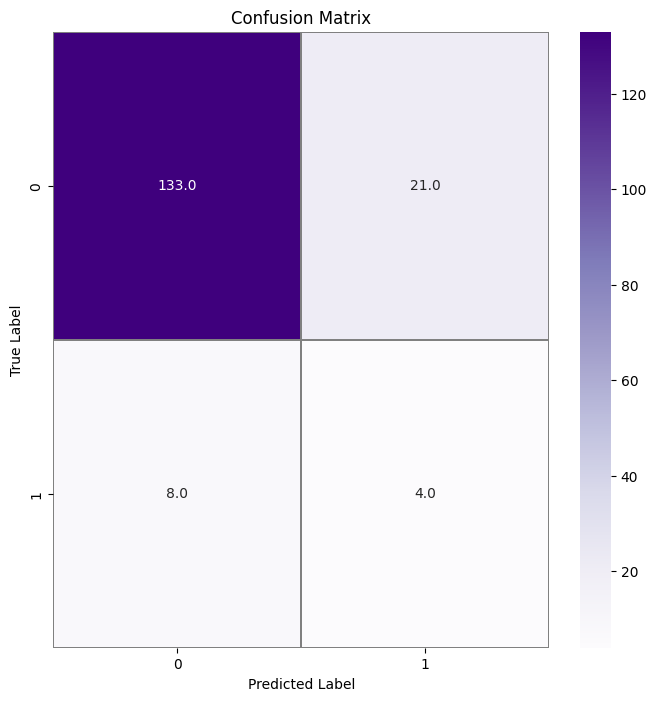

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       154
           1       0.16      0.33      0.22        12

    accuracy                           0.83       166
   macro avg       0.55      0.60      0.56       166
weighted avg       0.89      0.83      0.85       166

  Model Name  AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ANN-no-CW  0.6                     0.22      0.83         0.33   

   Specificity   PPV   NPV   PLR   NLR  
0         0.86  0.16  0.94  2.44  0.77  


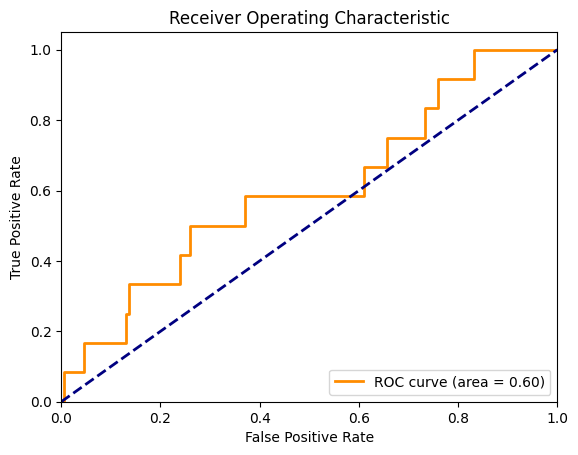

In [26]:
get_model_metrics(test_data=test_data, model=basic_model, model_name='ANN-no-CW')

# VGG16 NO TRANSFER LEARNING

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [28]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

train_data_rgb = train_data.map(convert_to_rgb)
val_data_rgb = val_data.map(convert_to_rgb)
test_data_rgb = test_data.map(convert_to_rgb)

prep_train_data = train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_val_data = val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_test_data = test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply to datasets
prep_train_data = prep_train_data.map(convert_to_grayscale)
prep_val_data = prep_val_data.map(convert_to_grayscale)
prep_test_data = prep_test_data.map(convert_to_grayscale)

In [29]:
train_data_augmented = prep_train_data.map(augment_image)

### With class weights

In [30]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='N')

# Model summary
model_VGG16.summary()

base_model.trainable set to True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14715231 (56.1

In [31]:
# Compilación de la red
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

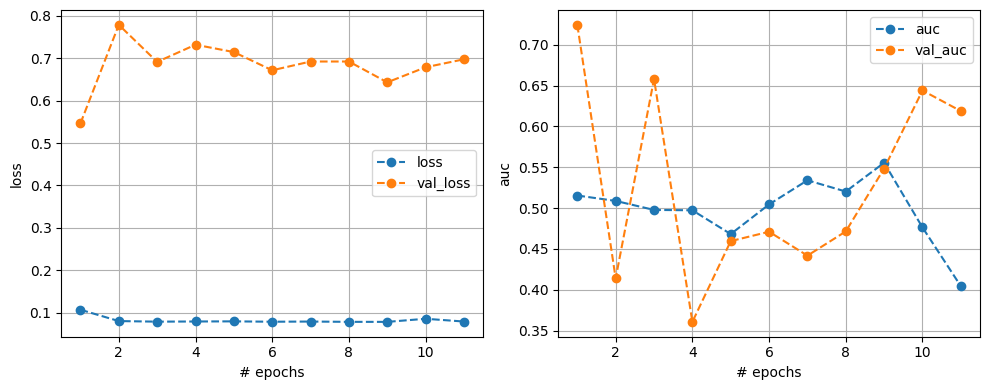

24/24 [==============================] - 7s 259ms/step - loss: 0.0791 - auc: 0.4045 - val_loss: 0.6975 - val_auc: 0.6189
Training time: 100.03128910064697 seconds


In [32]:
# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(train_data_augmented, #train_generator,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.00 with F1-score: 0.13


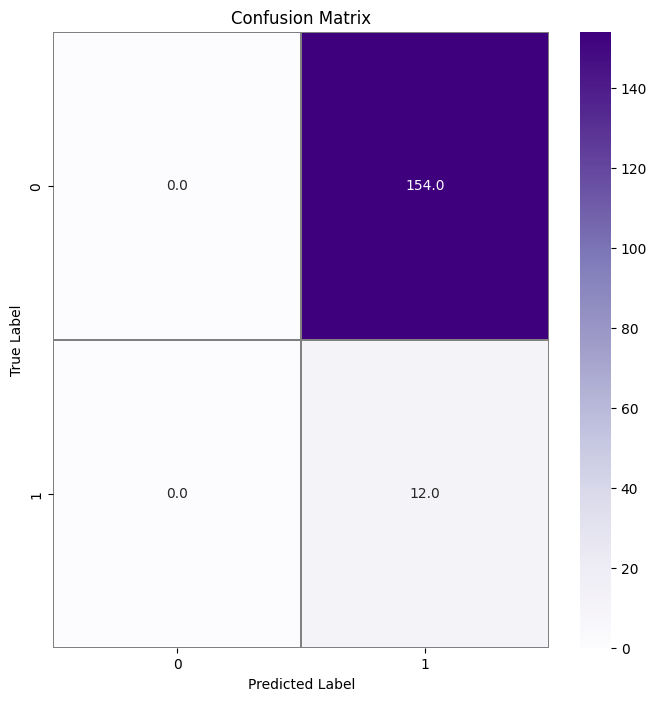

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_49259/1616972866.py:58: RuntimeWarning: invalid v

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.07      1.00      0.13        12

    accuracy                           0.07       166
   macro avg       0.04      0.50      0.07       166
weighted avg       0.01      0.07      0.01       166

    Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-no-TL  0.49                     0.13      0.07          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.07  NaN  1.0  NaN  


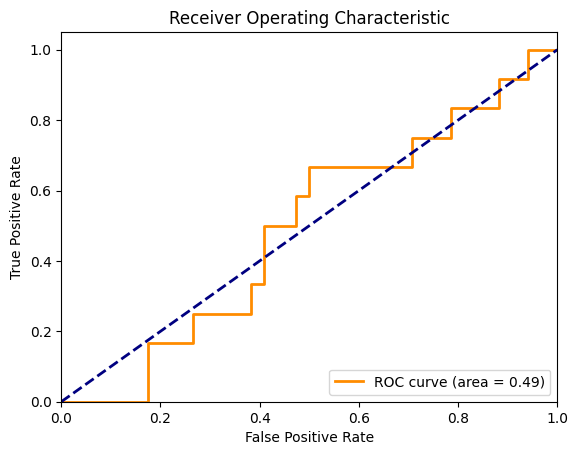

In [33]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-no-TL')

### Without class weights

In [34]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='N')

# Compilación de la red
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


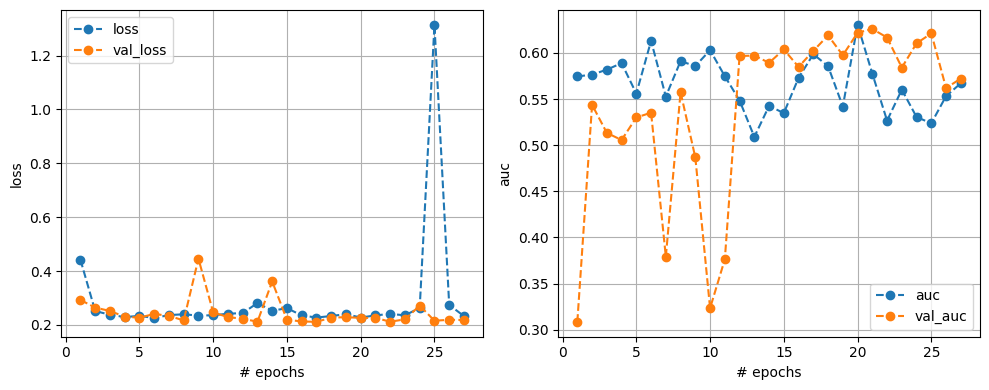

24/24 [==============================] - 7s 260ms/step - loss: 0.2330 - auc: 0.5671 - val_loss: 0.2187 - val_auc: 0.5722
Training time: 220.48645329475403 seconds


In [35]:
# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(train_data_augmented,#train_generator,
                    steps_per_epoch=len(train_data),
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    #class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.01 with F1-score: 0.13


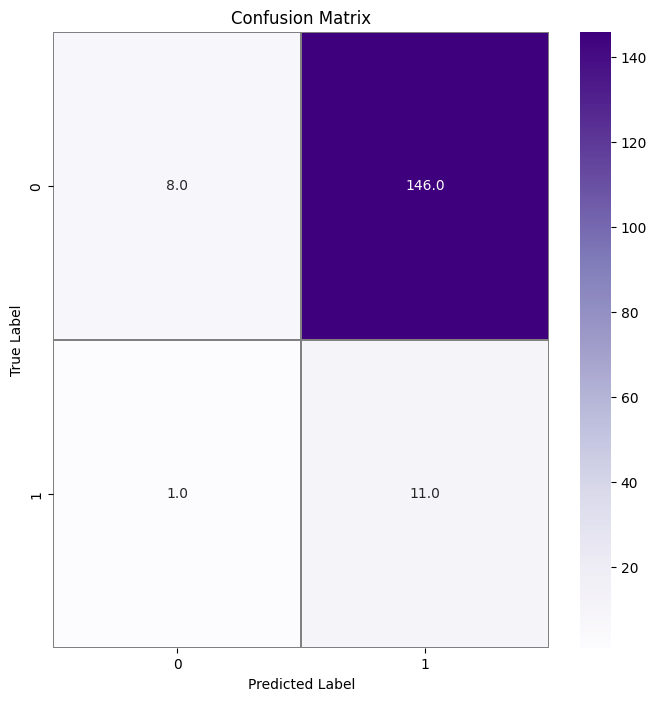

              precision    recall  f1-score   support

           0       0.89      0.05      0.10       154
           1       0.07      0.92      0.13        12

    accuracy                           0.11       166
   macro avg       0.48      0.48      0.11       166
weighted avg       0.83      0.11      0.10       166

          Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-no-TL-no-CW  0.25                     0.13      0.11         0.92   

   Specificity   PPV   NPV   PLR  NLR  
0         0.05  0.07  0.89  0.97  1.6  


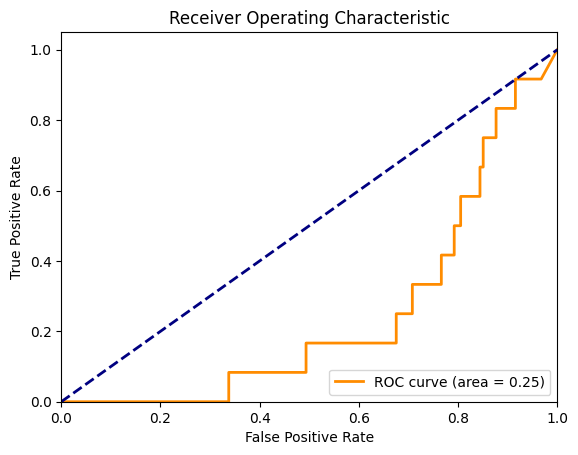

In [36]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-no-TL-no-CW')

# VGG TRANSFER LEARNING

### With class weights

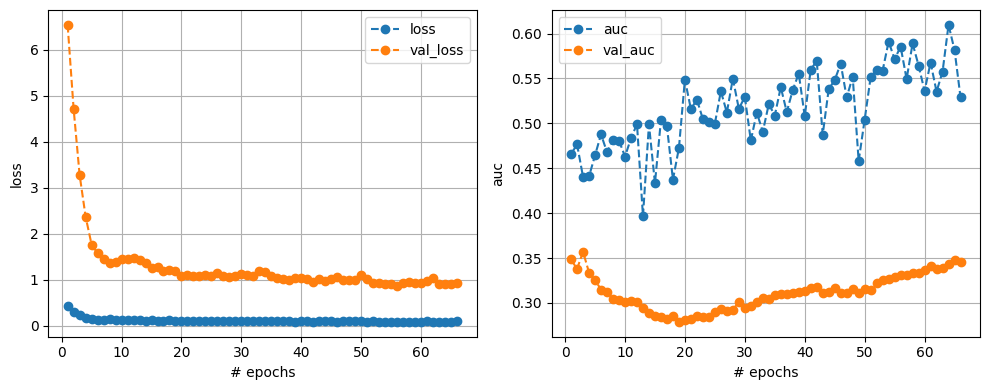

24/24 [==============================] - 6s 223ms/step - loss: 0.0943 - auc: 0.5291 - val_loss: 0.9232 - val_auc: 0.3456
Training time: 474.51029562950134 seconds


In [37]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='Y')
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(train_data_augmented,
                    steps_per_epoch=len(train_data),
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.68 with F1-score: 0.18


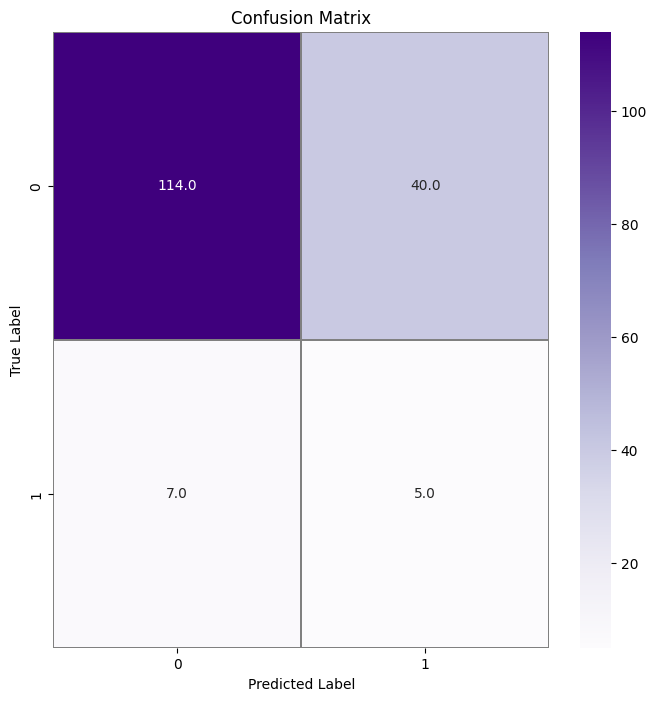

              precision    recall  f1-score   support

           0       0.94      0.74      0.83       154
           1       0.11      0.42      0.18        12

    accuracy                           0.72       166
   macro avg       0.53      0.58      0.50       166
weighted avg       0.88      0.72      0.78       166

  Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0   VGG16-TL  0.54                     0.18      0.72         0.42   

   Specificity   PPV   NPV  PLR   NLR  
0         0.74  0.11  0.94  1.6  0.79  


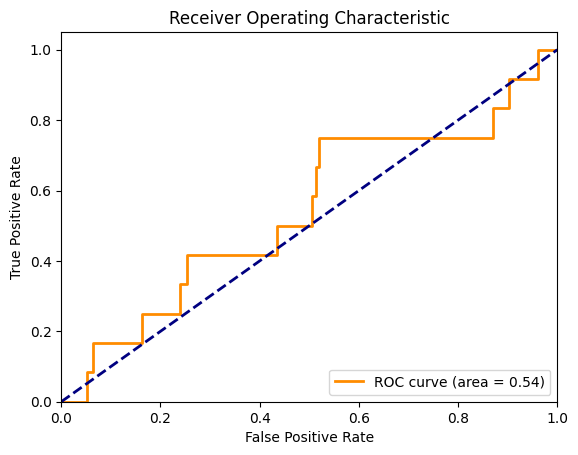

In [38]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-TL')

### Without class weights

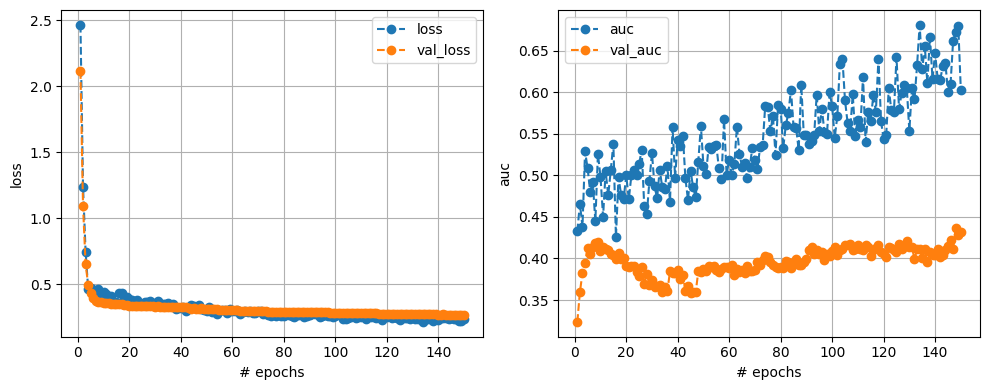

24/24 [==============================] - 6s 226ms/step - loss: 0.2377 - auc: 0.6026 - val_loss: 0.2655 - val_auc: 0.4322
Training time: 1065.579258441925 seconds


In [39]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='Y')
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(train_data_augmented,
                    steps_per_epoch=len(train_data),
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    #class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.00 with F1-score: 0.13


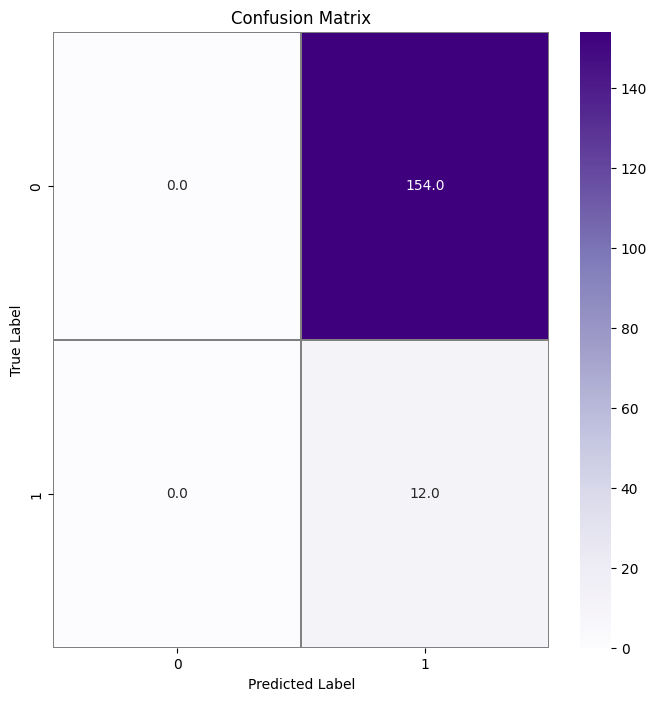

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_49259/1616972866.py:58: RuntimeWarning: invalid v

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.07      1.00      0.13        12

    accuracy                           0.07       166
   macro avg       0.04      0.50      0.07       166
weighted avg       0.01      0.07      0.01       166

       Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-TL-no-CW  0.39                     0.13      0.07          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.07  NaN  1.0  NaN  


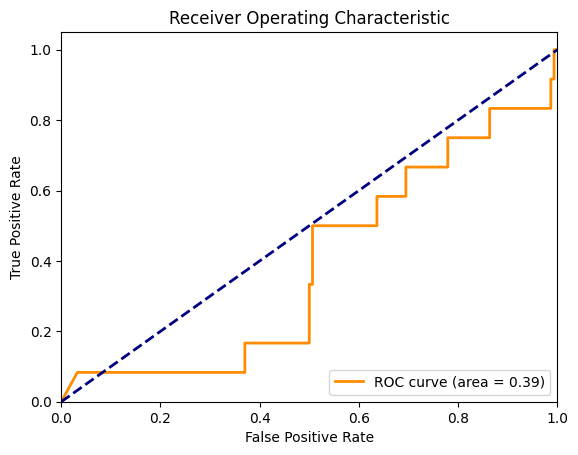

In [40]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-TL-no-CW')

# RESNET50 NO TRANSFER LEARNING

In [41]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

In [42]:
def preprocess_data_resnet50(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

In [43]:
train_data_rgb = train_data.map(convert_to_rgb)
val_data_rgb = val_data.map(convert_to_rgb)
test_data_rgb = test_data.map(convert_to_rgb)

In [44]:
# Map the preprocessing function to the datasets
prep_train_data = train_data_rgb.map(preprocess_data_resnet50)
prep_val_data = val_data_rgb.map(preprocess_data_resnet50)
prep_test_data = test_data_rgb.map(preprocess_data_resnet50)

In [45]:
# back to grayscale
prep_train_data = prep_train_data.map(convert_to_grayscale)
prep_val_data = prep_val_data.map(convert_to_grayscale)
prep_test_data = prep_test_data.map(convert_to_grayscale)

In [46]:
train_data_augmented = prep_train_data.map(augment_image)

### With class weights

In [47]:
# cargar modelo
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_resnet50 = build_model(base_model=base_model_resnet50, transfer_learning='N')

# Model summary
model_resnet50.summary()

base_model.trainable set to True
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589791 (89

In [48]:
# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

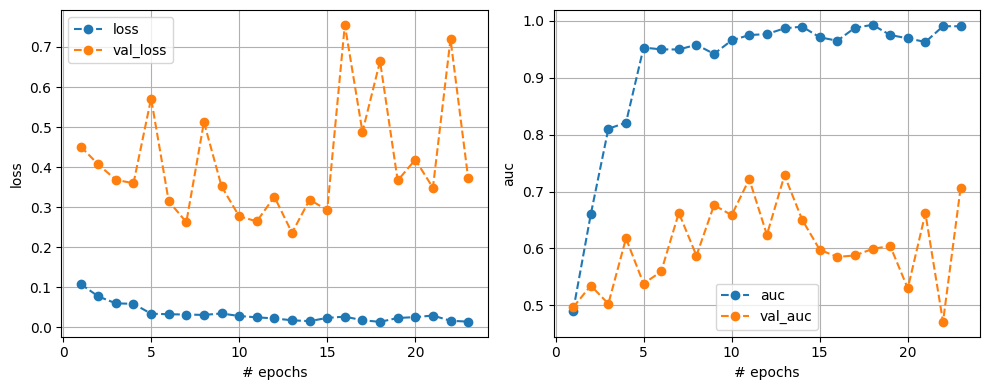

24/24 [==============================] - 7s 232ms/step - loss: 0.0145 - auc: 0.9903 - val_loss: 0.3733 - val_auc: 0.7067
Training time: 205.11665654182434 seconds


In [49]:
# Entrenamiento de la red
resnet_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
resnet_checkpoint = ModelCheckpoint('resnet50_best_weights.h5', save_best_only=True, save_weights_only=True)
resnet_plot_callback = PlotLearning()

start = time.time()

history = model_resnet50.fit(train_data_augmented, 
                    epochs=150, 
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data, 
                    callbacks=[resnet_callback, resnet_checkpoint, resnet_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.00 with F1-score: 0.13


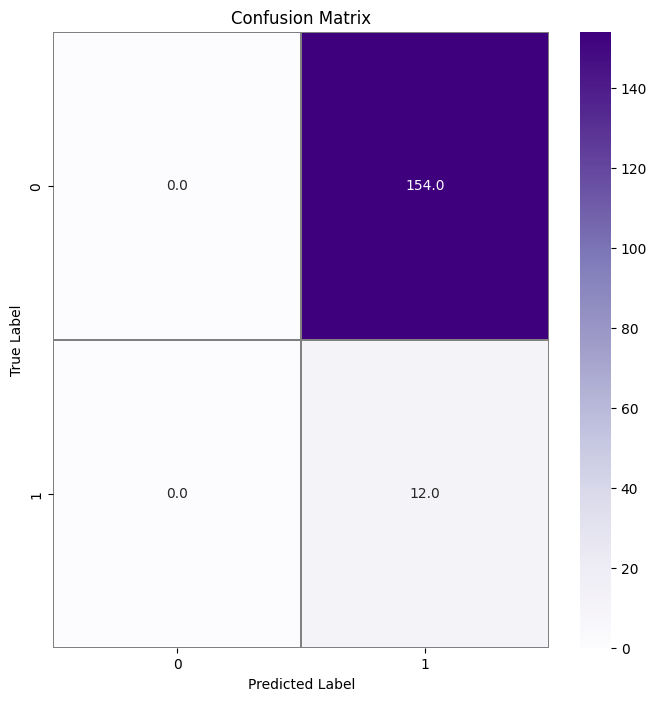

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_49259/1616972866.py:58: RuntimeWarning: invalid v

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.07      1.00      0.13        12

    accuracy                           0.07       166
   macro avg       0.04      0.50      0.07       166
weighted avg       0.01      0.07      0.01       166

       Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet50-no-TL  0.27                     0.13      0.07          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.07  NaN  1.0  NaN  


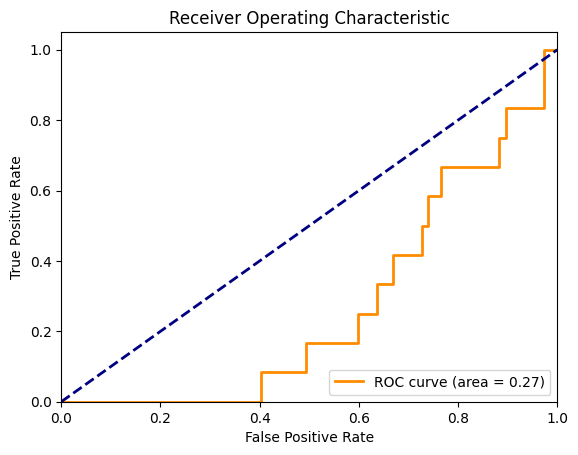

In [50]:
get_model_metrics(test_data=prep_test_data, model=model_resnet50, model_name='ResNet50-no-TL')

### Without class weights

In [51]:
# cargar modelo
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_resnet50 = build_model(base_model=base_model_resnet50, transfer_learning='N')

# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


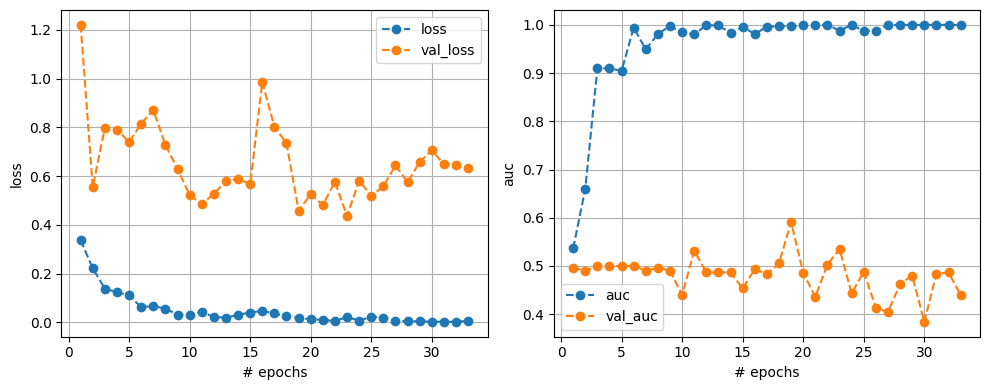

24/24 [==============================] - 6s 227ms/step - loss: 0.0067 - auc: 0.9999 - val_loss: 0.6320 - val_auc: 0.4400
Training time: 292.41860342025757 seconds


In [52]:
# Entrenamiento de la red
resnet_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
resnet_checkpoint = ModelCheckpoint('resnet50_best_weights.h5', save_best_only=True, save_weights_only=True)
resnet_plot_callback = PlotLearning()

start = time.time()

history = model_resnet50.fit(train_data_augmented, 
                    epochs=150, 
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data, 
                    callbacks=[resnet_callback, resnet_checkpoint, resnet_plot_callback],
                    #class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.00 with F1-score: 0.13


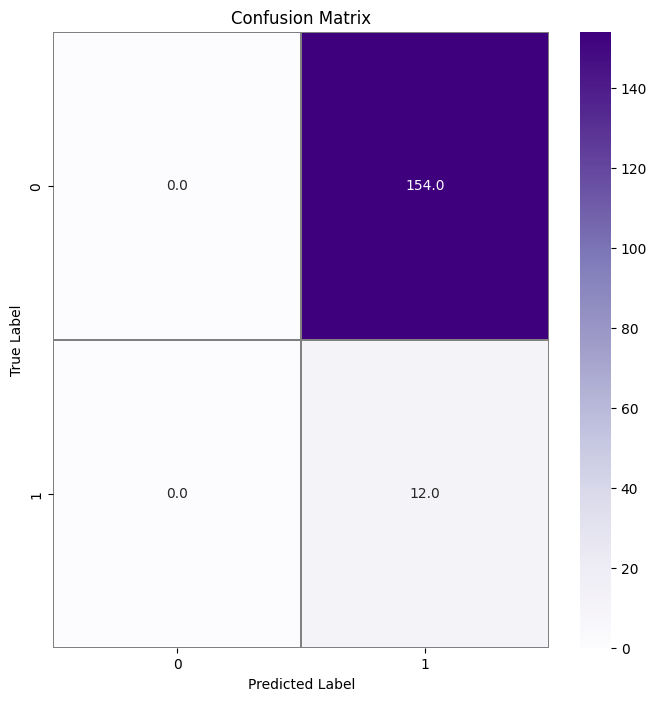

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_49259/1616972866.py:58: RuntimeWarning: invalid v

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.07      1.00      0.13        12

    accuracy                           0.07       166
   macro avg       0.04      0.50      0.07       166
weighted avg       0.01      0.07      0.01       166

             Model Name  AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet50-no-TL-no-CW  0.3                     0.13      0.07          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.07  NaN  1.0  NaN  


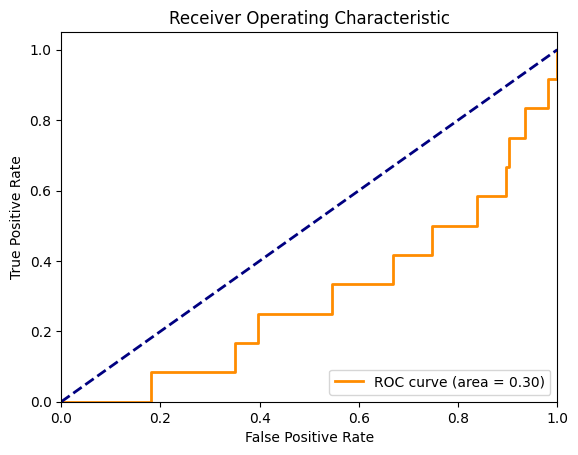

In [53]:
get_model_metrics(test_data=prep_test_data, model=model_resnet50, model_name='ResNet50-no-TL-no-CW')

# RESNET50 TRANSFER LEARNING

### With class weights

In [54]:
# cargar modelo
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_resnet50 = build_model(base_model=base_model_resnet50, transfer_learning='Y')

# Model summary
model_resnet50.summary()

base_model.trainable set to False
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 23589791 (8

In [55]:
# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

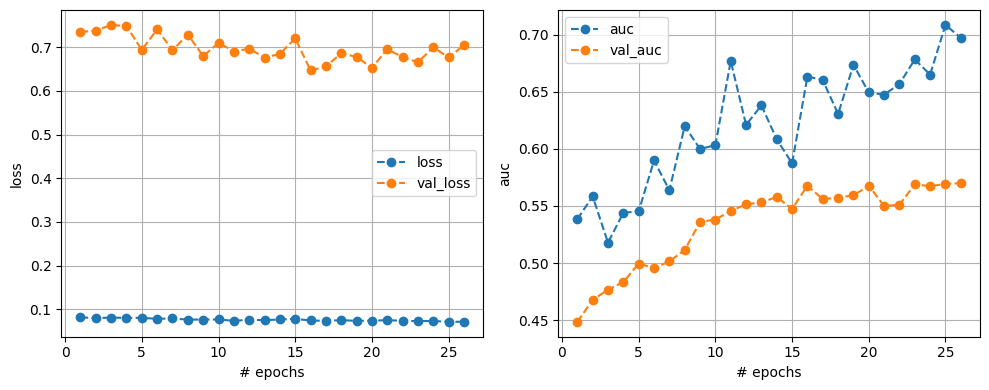

24/24 [==============================] - 6s 212ms/step - loss: 0.0718 - auc: 0.6970 - val_loss: 0.7048 - val_auc: 0.5700
Training time: 185.6441032886505 seconds


In [56]:
# Entrenamiento de la red
resnet_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
resnet_tl_checkpoint = ModelCheckpoint('resnet50_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
resnet_tl_plot_callback = PlotLearning()

start = time.time()

history = model_resnet50.fit(train_data_augmented, 
                    epochs=150, 
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data, 
                    callbacks=[resnet_tl_callback, resnet_tl_checkpoint, resnet_tl_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.31 with F1-score: 0.14


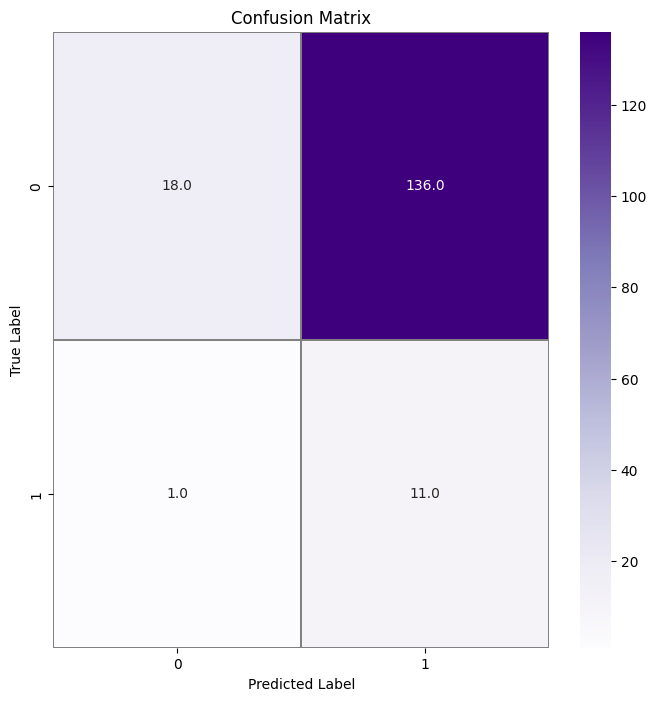

              precision    recall  f1-score   support

           0       0.95      0.12      0.21       154
           1       0.07      0.92      0.14        12

    accuracy                           0.17       166
   macro avg       0.51      0.52      0.17       166
weighted avg       0.88      0.17      0.20       166

    Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet50-TL  0.34                     0.14      0.17         0.92   

   Specificity   PPV   NPV   PLR   NLR  
0         0.12  0.07  0.95  1.04  0.71  


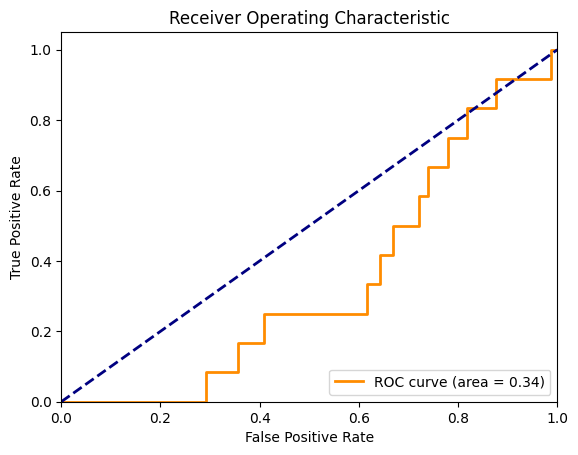

In [57]:
get_model_metrics(test_data=prep_test_data, model=model_resnet50, model_name='ResNet50-TL')

### Without class weights

In [58]:
# cargar modelo
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_resnet50 = build_model(base_model=base_model_resnet50, transfer_learning='Y')

# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


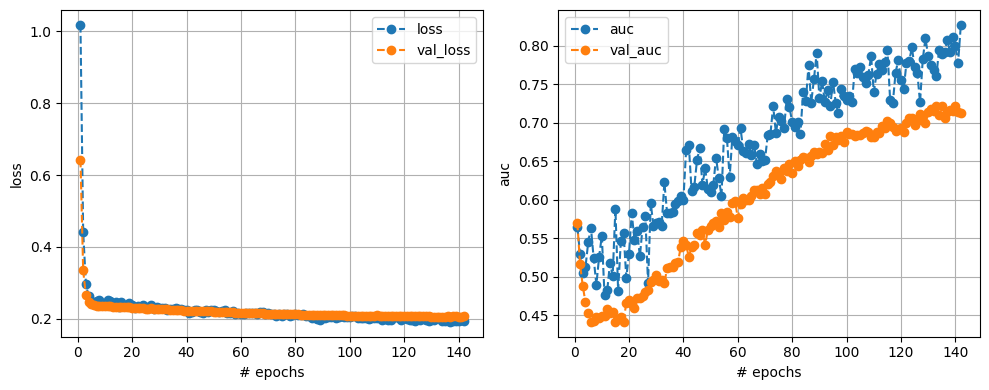

24/24 [==============================] - 6s 223ms/step - loss: 0.1936 - auc: 0.8270 - val_loss: 0.2067 - val_auc: 0.7122
Training time: 1084.165631055832 seconds


In [59]:
# Entrenamiento de la red
resnet_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
resnet_tl_checkpoint = ModelCheckpoint('resnet50_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
resnet_tl_plot_callback = PlotLearning()

start = time.time()

history = model_resnet50.fit(train_data_augmented, 
                    epochs=150, 
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data, 
                    callbacks=[resnet_tl_callback, resnet_tl_checkpoint, resnet_tl_plot_callback],
                    #class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.00 with F1-score: 0.13


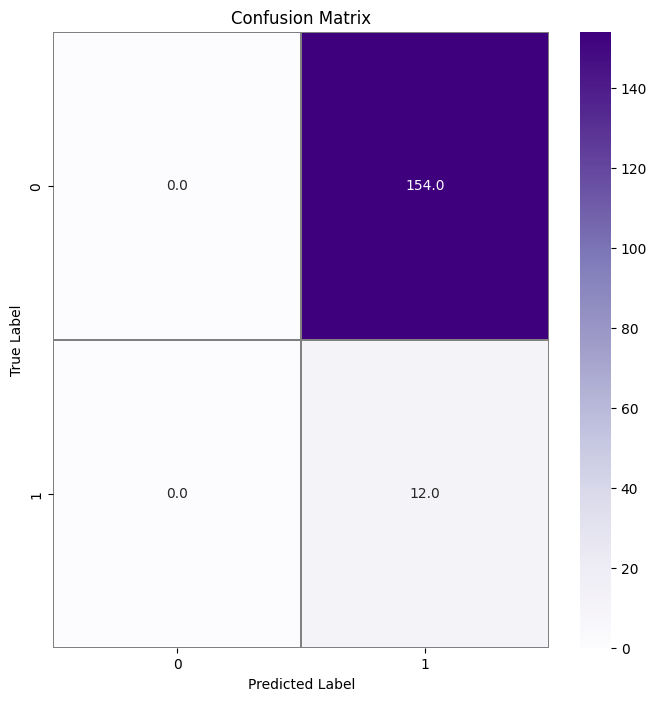

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_49259/1616972866.py:58: RuntimeWarning: invalid v

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.07      1.00      0.13        12

    accuracy                           0.07       166
   macro avg       0.04      0.50      0.07       166
weighted avg       0.01      0.07      0.01       166

          Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet50-TL-no-CW  0.31                     0.13      0.07          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.07  NaN  1.0  NaN  


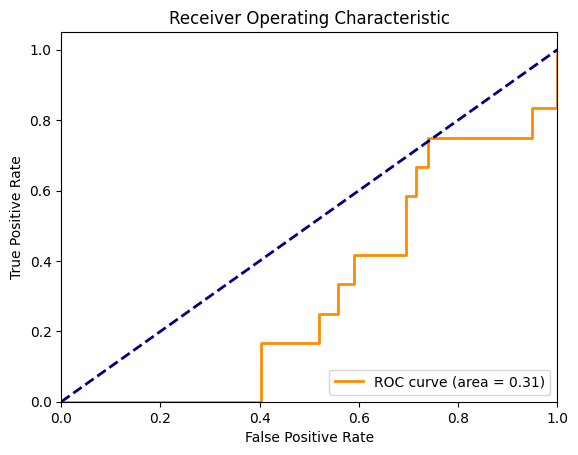

In [60]:
get_model_metrics(test_data=prep_test_data, model=model_resnet50, model_name='ResNet50-TL-no-CW')

# MobileNet (no TL)

In [61]:
from tensorflow.keras.applications import MobileNet

In [62]:
def preprocess_data_mobilenet(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

# Map the preprocessing function to the datasets
prep_train_data = train_data.map(preprocess_data_mobilenet)
prep_val_data = val_data.map(preprocess_data_mobilenet)
prep_test_data = test_data.map(preprocess_data_mobilenet)


In [63]:
train_data_augmented = prep_train_data.map(augment_image)

### With class weights

In [64]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='N')

# model summary
model_mobilenet.summary()

base_model.trainable set to True
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_8  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 1)                 1025      
                          

In [65]:
# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

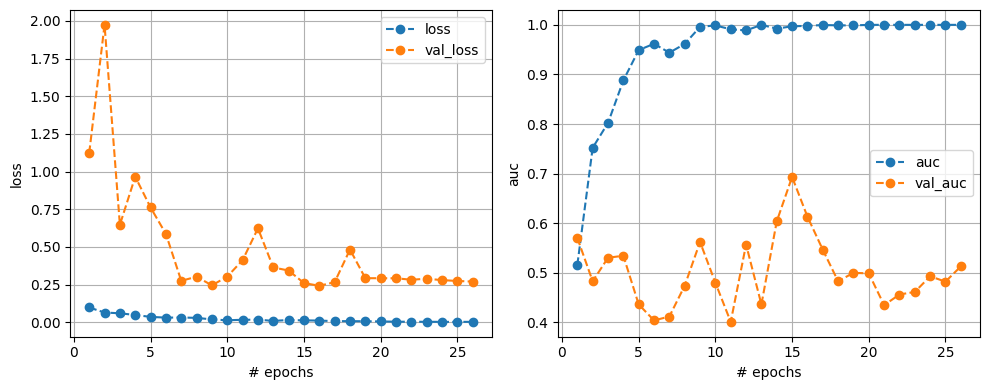

24/24 [==============================] - 4s 139ms/step - loss: 0.0026 - auc: 1.0000 - val_loss: 0.2698 - val_auc: 0.5130
Training time: 127.60420823097229 seconds


In [66]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.01 with F1-score: 0.19


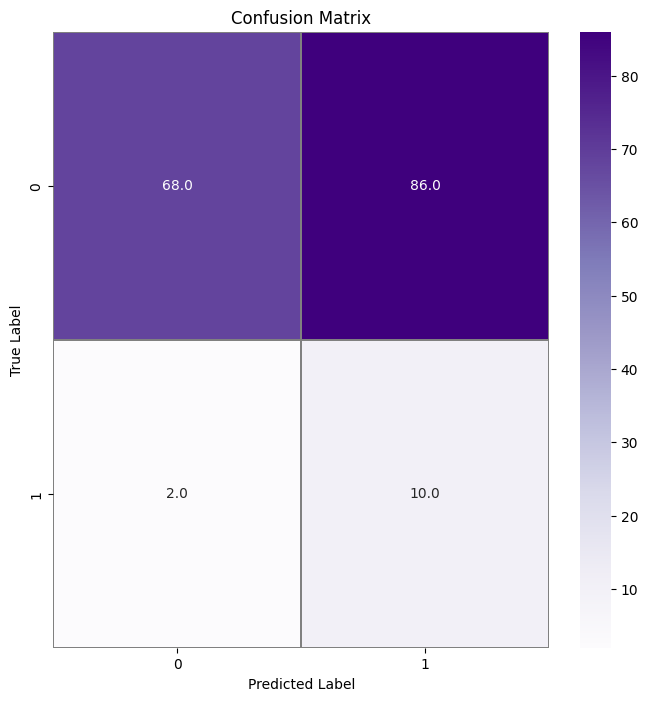

              precision    recall  f1-score   support

           0       0.97      0.44      0.61       154
           1       0.10      0.83      0.19        12

    accuracy                           0.47       166
   macro avg       0.54      0.64      0.40       166
weighted avg       0.91      0.47      0.58       166

        Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  MobileNet-no-TL  0.56                     0.19      0.47         0.83   

   Specificity  PPV   NPV   PLR   NLR  
0         0.44  0.1  0.97  1.49  0.38  


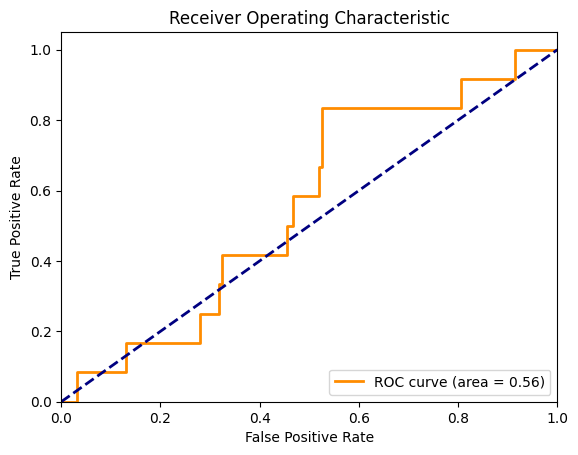

In [67]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-no-TL')

### Without class weights

In [68]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='N')

# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


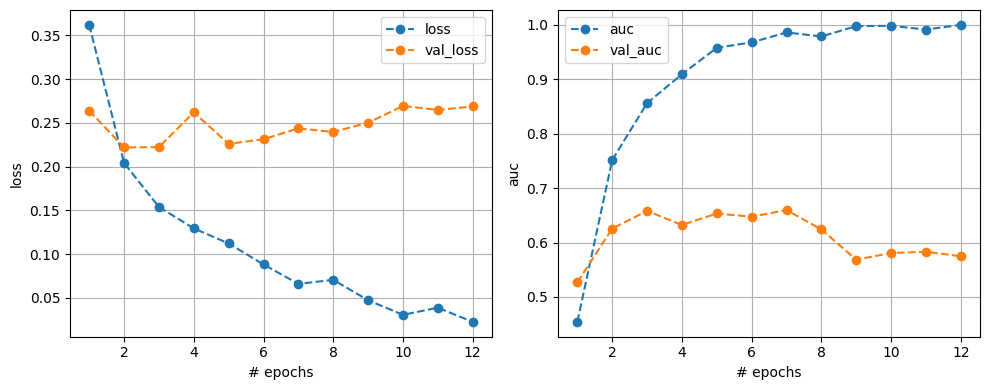

24/24 [==============================] - 4s 135ms/step - loss: 0.0226 - auc: 1.0000 - val_loss: 0.2688 - val_auc: 0.5748
Training time: 62.76689028739929 seconds


In [69]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    #class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.05 with F1-score: 0.16


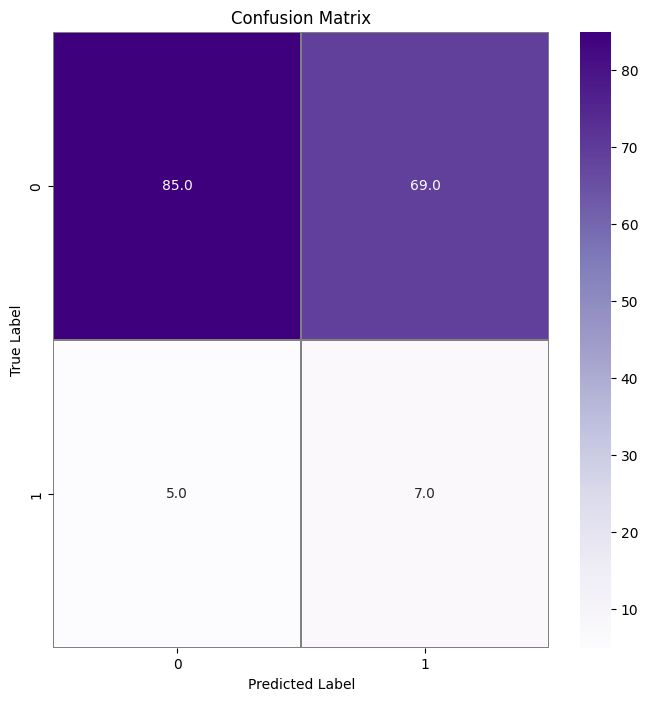

              precision    recall  f1-score   support

           0       0.94      0.55      0.70       154
           1       0.09      0.58      0.16        12

    accuracy                           0.55       166
   macro avg       0.52      0.57      0.43       166
weighted avg       0.88      0.55      0.66       166

              Model Name  AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  MobileNet-no-TL-no-CW  0.5                     0.16      0.55         0.58   

   Specificity   PPV   NPV  PLR   NLR  
0         0.55  0.09  0.94  1.3  0.75  


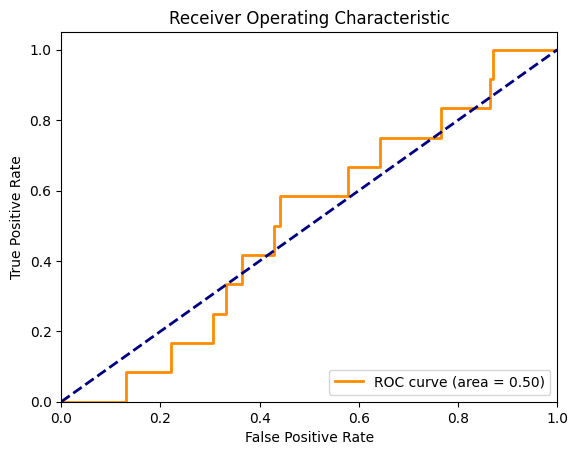

In [70]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-no-TL-no-CW')

# MobileNet (TL)

### With class weights

In [71]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='Y')

# model summary
model_mobilenet.summary()

base_model.trainable set to False
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_14 (Dense)            (None, 1)                 1025      
                        

In [72]:
# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

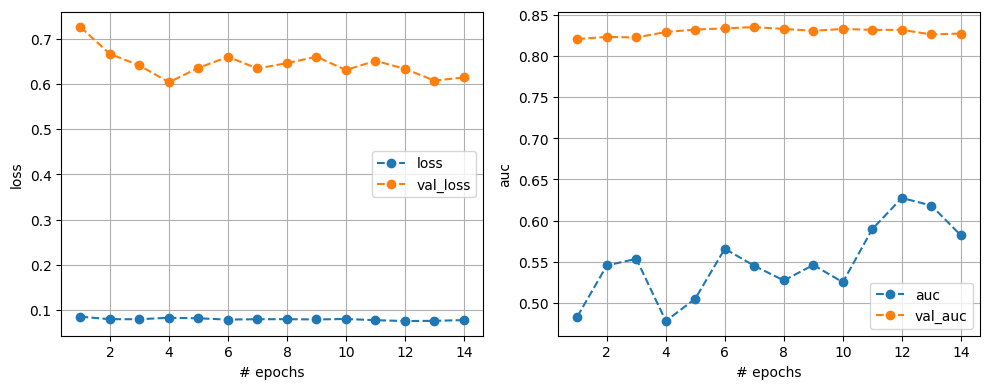

24/24 [==============================] - 4s 136ms/step - loss: 0.0778 - auc: 0.5822 - val_loss: 0.6141 - val_auc: 0.8270
Training time: 60.254117488861084 seconds


In [73]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.25 with F1-score: 0.14


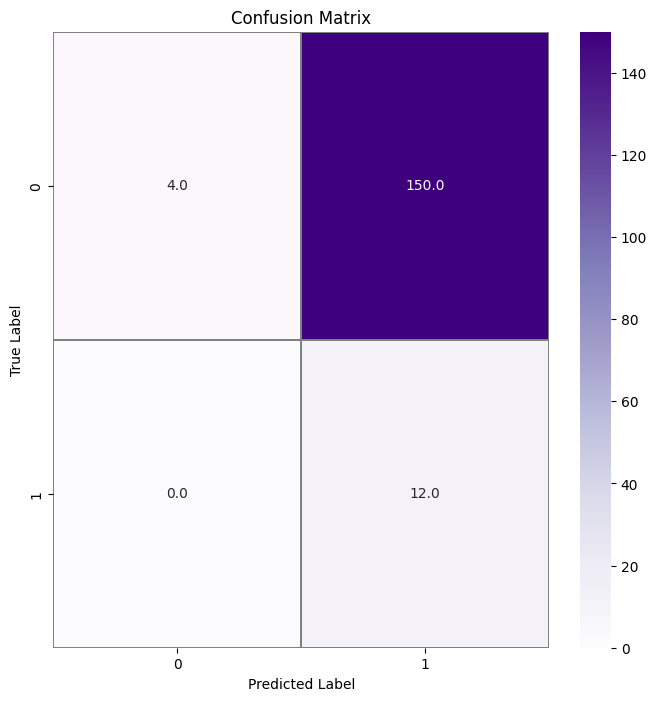

              precision    recall  f1-score   support

           0       1.00      0.03      0.05       154
           1       0.07      1.00      0.14        12

    accuracy                           0.10       166
   macro avg       0.54      0.51      0.09       166
weighted avg       0.93      0.10      0.06       166

     Model Name  AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  MobileNet-TL  0.3                     0.14       0.1          1.0   

   Specificity   PPV  NPV   PLR  NLR  
0         0.03  0.07  1.0  1.03  0.0  


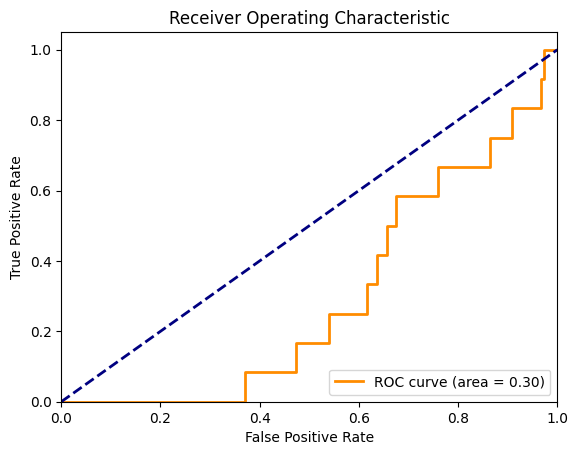

In [74]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-TL')

### Without class weights

In [75]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='Y')

# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


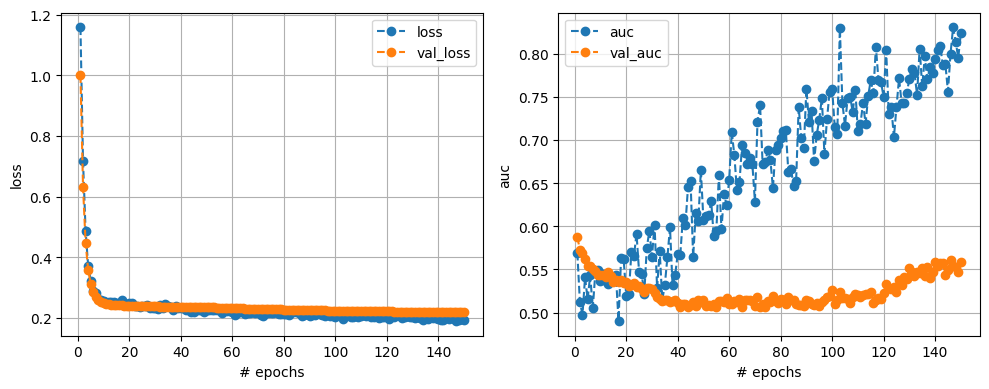

24/24 [==============================] - 4s 133ms/step - loss: 0.1915 - auc: 0.8235 - val_loss: 0.2183 - val_auc: 0.5581
Training time: 631.9308416843414 seconds


In [76]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    #class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.09 with F1-score: 0.14


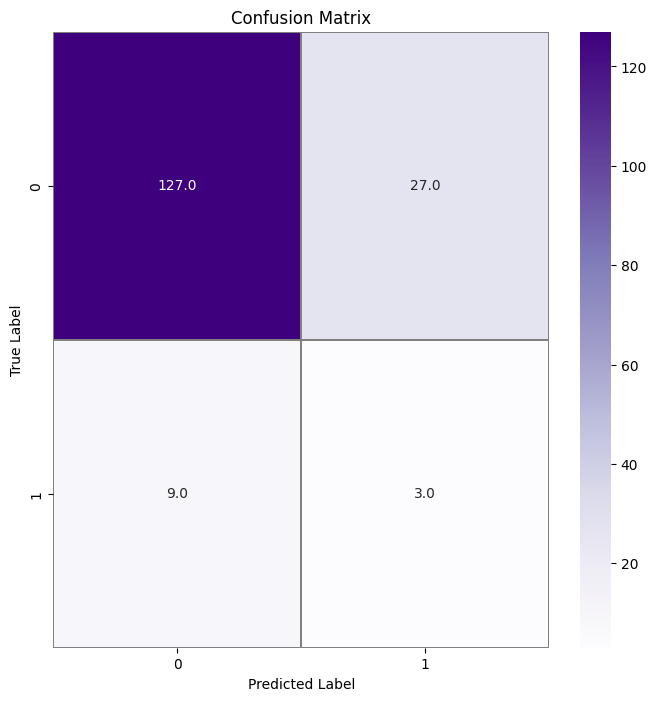

              precision    recall  f1-score   support

           0       0.93      0.82      0.88       154
           1       0.10      0.25      0.14        12

    accuracy                           0.78       166
   macro avg       0.52      0.54      0.51       166
weighted avg       0.87      0.78      0.82       166

           Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  MobileNet-TL-no-CW  0.45                     0.14      0.78         0.25   

   Specificity  PPV   NPV   PLR   NLR  
0         0.82  0.1  0.93  1.43  0.91  


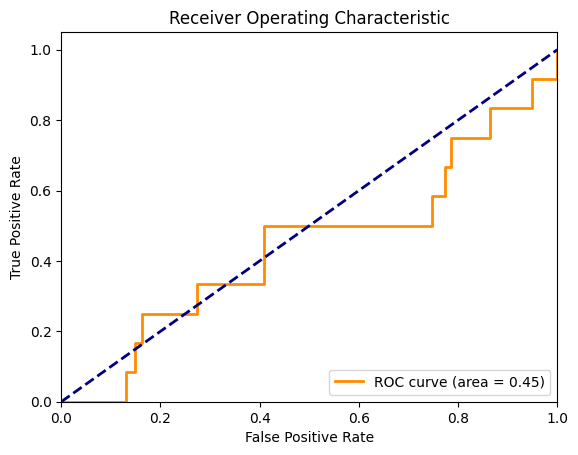

In [77]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-TL-no-CW')

# ResNet18 (no TL)

In [78]:
!pip install image-classifiers

In [79]:
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

In [80]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

prep_train_data = train_data.map(preprocess_data_resnet18)
prep_val_data = val_data.map(preprocess_data_resnet18)
prep_test_data = test_data.map(preprocess_data_resnet18)

In [81]:
train_data_augmented = prep_train_data.map(augment_image)

### With class weights

In [82]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='N')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


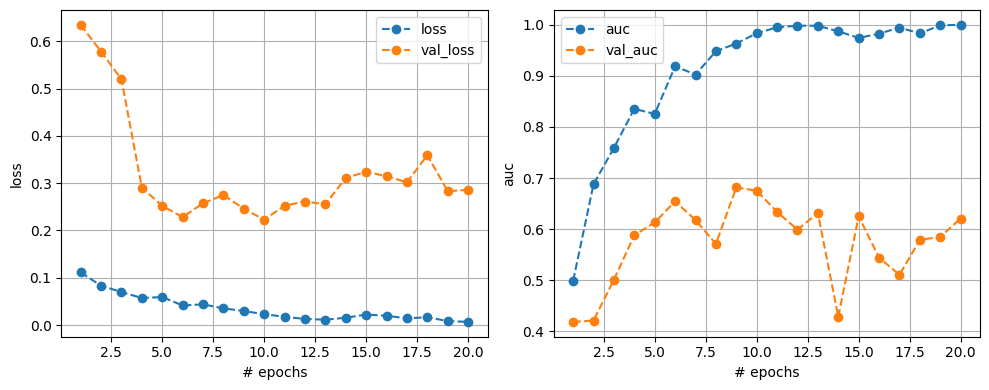

24/24 [==============================] - 4s 142ms/step - loss: 0.0068 - auc: 0.9997 - val_loss: 0.2860 - val_auc: 0.6207


In [83]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=class_weights_dict
                    )

Best threshold: 0.00 with F1-score: 0.13


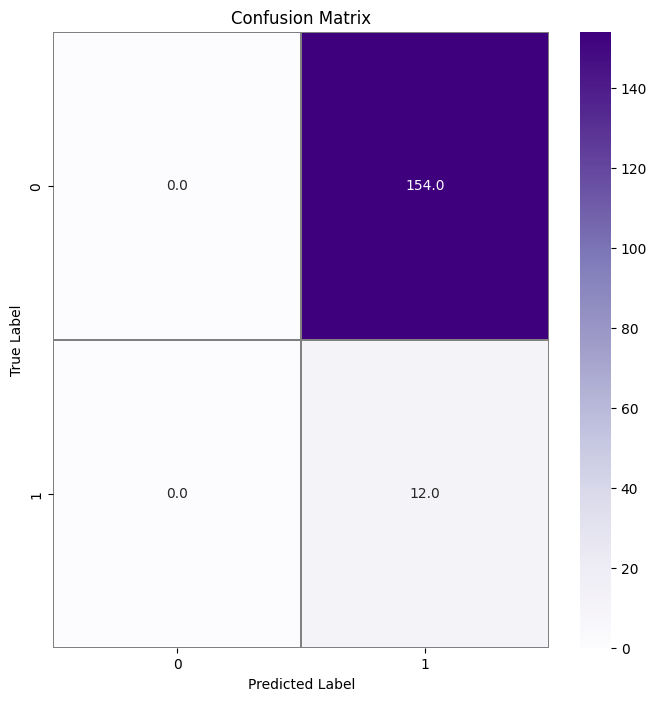

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_49259/1616972866.py:58: RuntimeWarning: invalid v

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.07      1.00      0.13        12

    accuracy                           0.07       166
   macro avg       0.04      0.50      0.07       166
weighted avg       0.01      0.07      0.01       166

       Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-no-TL  0.25                     0.13      0.07          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.07  NaN  1.0  NaN  


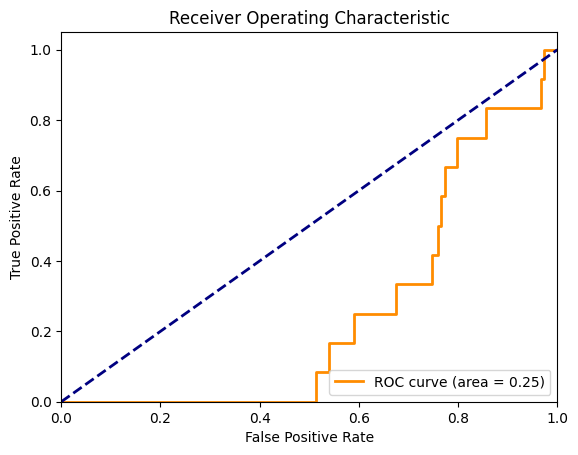

In [84]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-no-TL')

### Without class weights

In [85]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='N')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


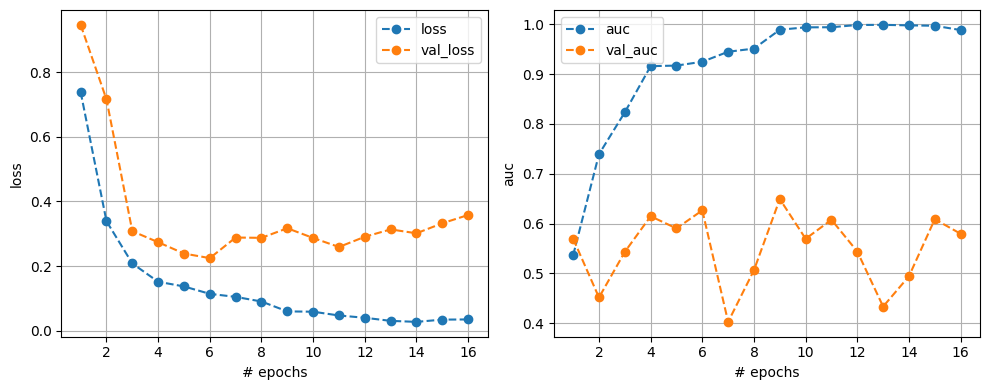

24/24 [==============================] - 4s 138ms/step - loss: 0.0353 - auc: 0.9883 - val_loss: 0.3581 - val_auc: 0.5796


In [86]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    #class_weight=class_weights_dict
                    )

Best threshold: 0.00 with F1-score: 0.13


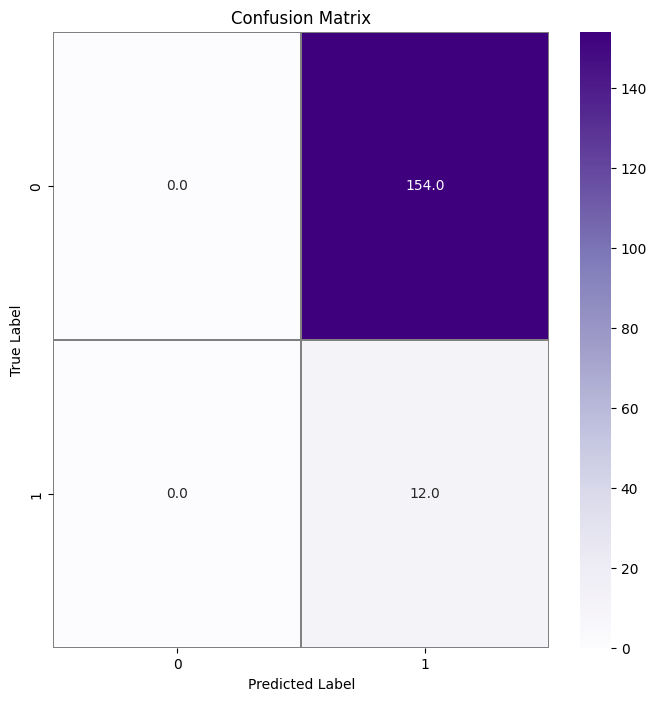

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_49259/1616972866.py:58: RuntimeWarning: invalid v

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.07      1.00      0.13        12

    accuracy                           0.07       166
   macro avg       0.04      0.50      0.07       166
weighted avg       0.01      0.07      0.01       166

             Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-no-TL-no-CW  0.51                     0.13      0.07          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.07  NaN  1.0  NaN  


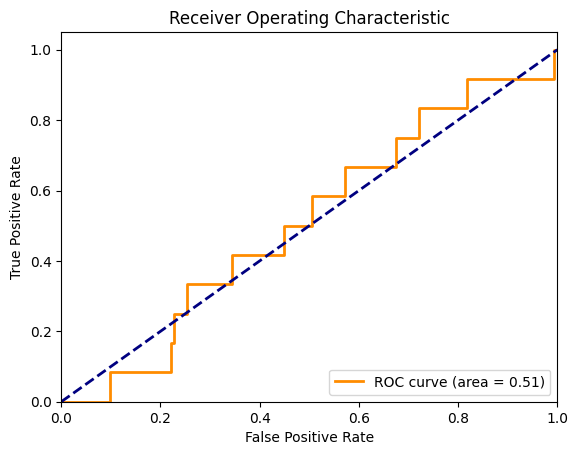

In [87]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-no-TL-no-CW')

# ResNet18 (TL)

### With class weights

In [88]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


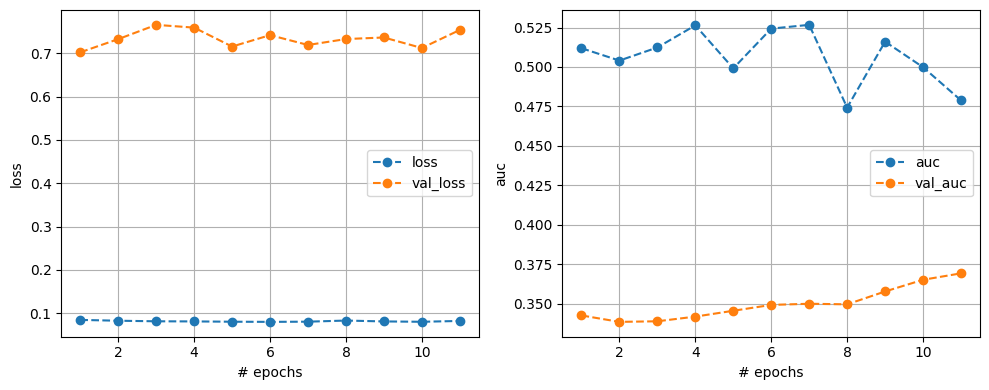

24/24 [==============================] - 4s 135ms/step - loss: 0.0823 - auc: 0.4788 - val_loss: 0.7536 - val_auc: 0.3693


In [89]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=class_weights_dict
                    )

Best threshold: 0.63 with F1-score: 0.22


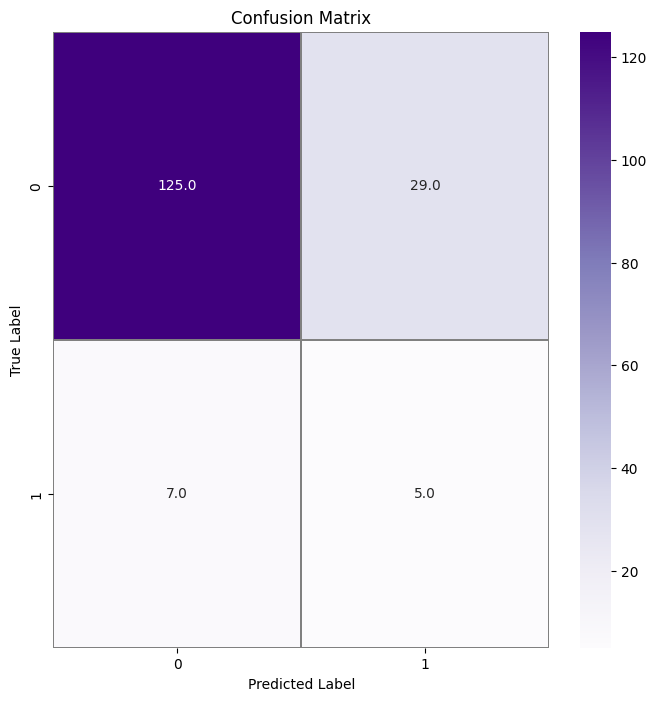

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       154
           1       0.15      0.42      0.22        12

    accuracy                           0.78       166
   macro avg       0.55      0.61      0.55       166
weighted avg       0.89      0.78      0.83       166

    Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-TL  0.56                     0.22      0.78         0.42   

   Specificity   PPV   NPV   PLR   NLR  
0         0.81  0.15  0.95  2.21  0.72  


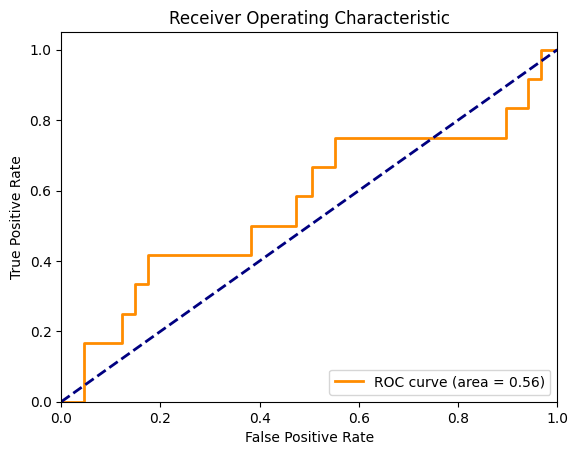

In [90]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-TL')

### Without class weights

In [91]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


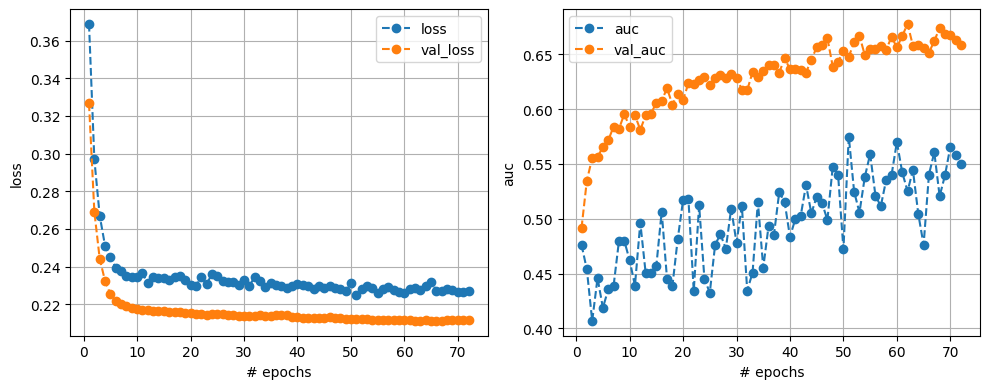

24/24 [==============================] - 4s 142ms/step - loss: 0.2272 - auc: 0.5504 - val_loss: 0.2115 - val_auc: 0.6585


In [92]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    #class_weight=class_weights_dict
                    )

Best threshold: 0.09 with F1-score: 0.36


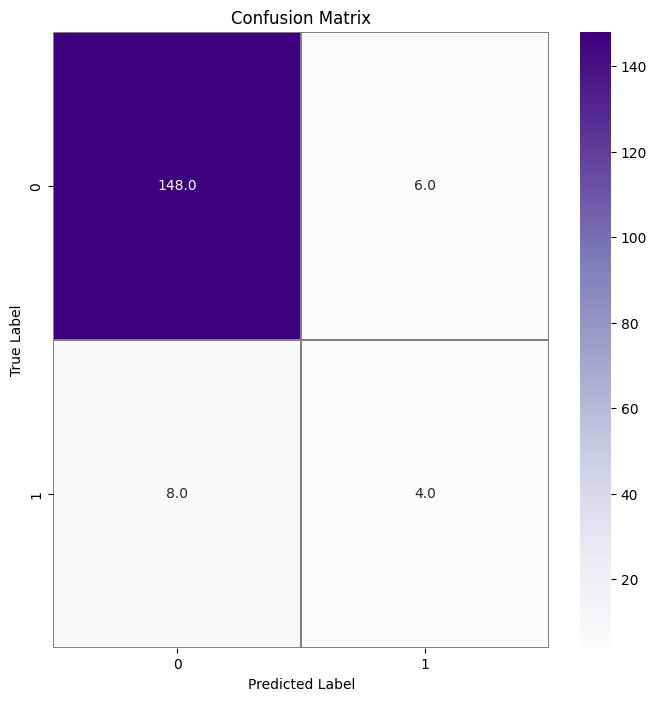

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       154
           1       0.40      0.33      0.36        12

    accuracy                           0.92       166
   macro avg       0.67      0.65      0.66       166
weighted avg       0.91      0.92      0.91       166

          Model Name  AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-TL-no-CW  0.7                     0.36      0.92         0.33   

   Specificity  PPV   NPV   PLR   NLR  
0         0.96  0.4  0.95  8.56  0.69  


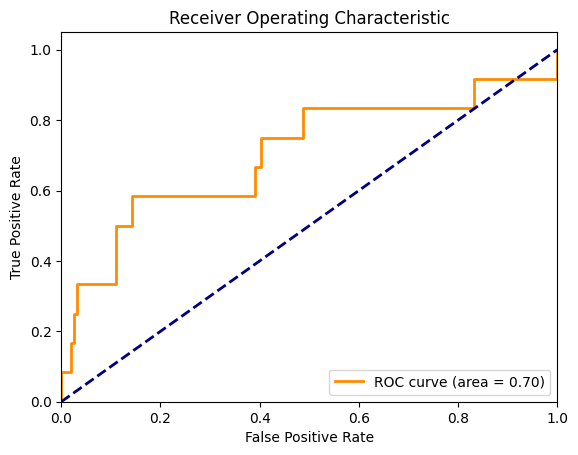

In [93]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-TL-no-CW')